# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### Importando librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

### Importando datos

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Podemos observar que:
* Tenemos un dataframe con 26,496 filas no nulas
* Se compone de 2 columnas
    * datetime de tipo object : Contiene la temporalidad de las ordenes en fecha y hora
    * num_orders : contiene la cantidad de órdenes para el periodo dado

Para este proyecto vamos a requerir analizar intervalos de una hora, para esto necesitaremos transformar la columna 'datetime' a tipo de dato datetime, por otro lado requeriremos remuestreo de datos para que se generen los intervalos por hora.

In [5]:
#Cambiando el tipo de dato a datetime
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Remuestreo de datos

In [6]:
#Estableciendo la columna 'datetime' como index
data = data.set_index('datetime')

In [7]:
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Descomponiendo datos para verificar tendencia y estacionalidad 
*En ventanas de tiempo de días (unidad) y de las últimas 2 semanas registrada (datos más recientes)*

In [8]:
#remuestreando datos a intervalos de un día para observar tendencias por día
data1 = data.resample('1D').mean()
data1.head(2)

,num_orders
datetime,
2018-03-01,9.472222
2018-03-02,10.458333


In [9]:
#Obteniendo las fechas (indices) de los últimos 7 días
data1_w_dow= data1.copy()
data1_w_dow['dayofweek']  = data1.index.dayofweek
in_date ='2018-08-13'
in_date2 ='2018-08-25'
fin_date = '2018-08-29'
data1_w_dow[in_date:fin_date].head()



,num_orders,dayofweek
datetime,,
2018-08-13,23.305556,0
2018-08-14,19.916667,1
2018-08-15,20.437500,2
2018-08-16,21.437500,3
2018-08-17,22.527778,4


In [10]:
#remuestreando datos a intervalos de una hora para observar tendencias de las últimas 2 semana (los datos más recientes)
data_week = data[in_date:fin_date].resample('1H').mean()

#remuestreando datos a intervalos de una hora para observar la estacionalidad de los últimos 5 días (los datos más recientes)
data_week1 = data[in_date2:fin_date].resample('1H').mean()

data_week.head()

,num_orders
datetime,
2018-08-13 00:00:00,26.666667
2018-08-13 01:00:00,45.500000
2018-08-13 02:00:00,72.833333
2018-08-13 03:00:00,28.000000
2018-08-13 04:00:00,23.833333


In [11]:
#Descomponiendo los datos para analizarlos por día para todo el dataset
decomposed_day = seasonal_decompose(data1)

In [12]:
#Descomponiendo los datos para analizarlos en el periodo de las últimas 2 semanas
decomposed_week = seasonal_decompose(data_week)

In [13]:
#Descomponiendo los datos para analizarlos en el periodo de los últimos 5 días
decomposed_week_by_hour = seasonal_decompose(data_week1)

### Creación de columnas  características

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range (1,max_lag+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    data['rolling_mean']= data['num_orders'].rolling(rolling_mean_size).mean().shift()
    

In [15]:
make_features(data,20,4)
data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,9,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 00:10:00,14,2018,3,1,3,9.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 00:20:00,28,2018,3,1,3,14.0,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 00:30:00,20,2018,3,1,3,28.0,14.0,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 00:40:00,32,2018,3,1,3,20.0,28.0,14.0,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.75


### Definición de características y objetivo

In [16]:
target = 'num_orders'
features = [i for i in data.columns if i not in target]
features

['year',
 'month',
 'day',
 'dayofweek',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'rolling_mean']

### Generando datos de entrenamiento y prueba

In [17]:
train , test = train_test_split(data, shuffle = False ,test_size = 0.1)
print(train.shape)
print(test.shape)

(23846, 26)
(2650, 26)


In [18]:
decomposed_week_by_hour.trend

datetime
2018-08-25 00:00:00   NaN
2018-08-25 01:00:00   NaN
2018-08-25 02:00:00   NaN
2018-08-25 03:00:00   NaN
2018-08-25 04:00:00   NaN
                       ..
2018-08-29 19:00:00   NaN
2018-08-29 20:00:00   NaN
2018-08-29 21:00:00   NaN
2018-08-29 22:00:00   NaN
2018-08-29 23:00:00   NaN
Freq: H, Name: trend, Length: 120, dtype: float64

## Análisis

Estudiando estacionalidad y tendencias en nuestros datos (en ventanas de tiempo de 1 día)

Text(0.5, 1.0, 'Estacionalidad por hora en una ventana de 24 horas para un periodo de 5 días')

<Figure size 640x480 with 0 Axes>

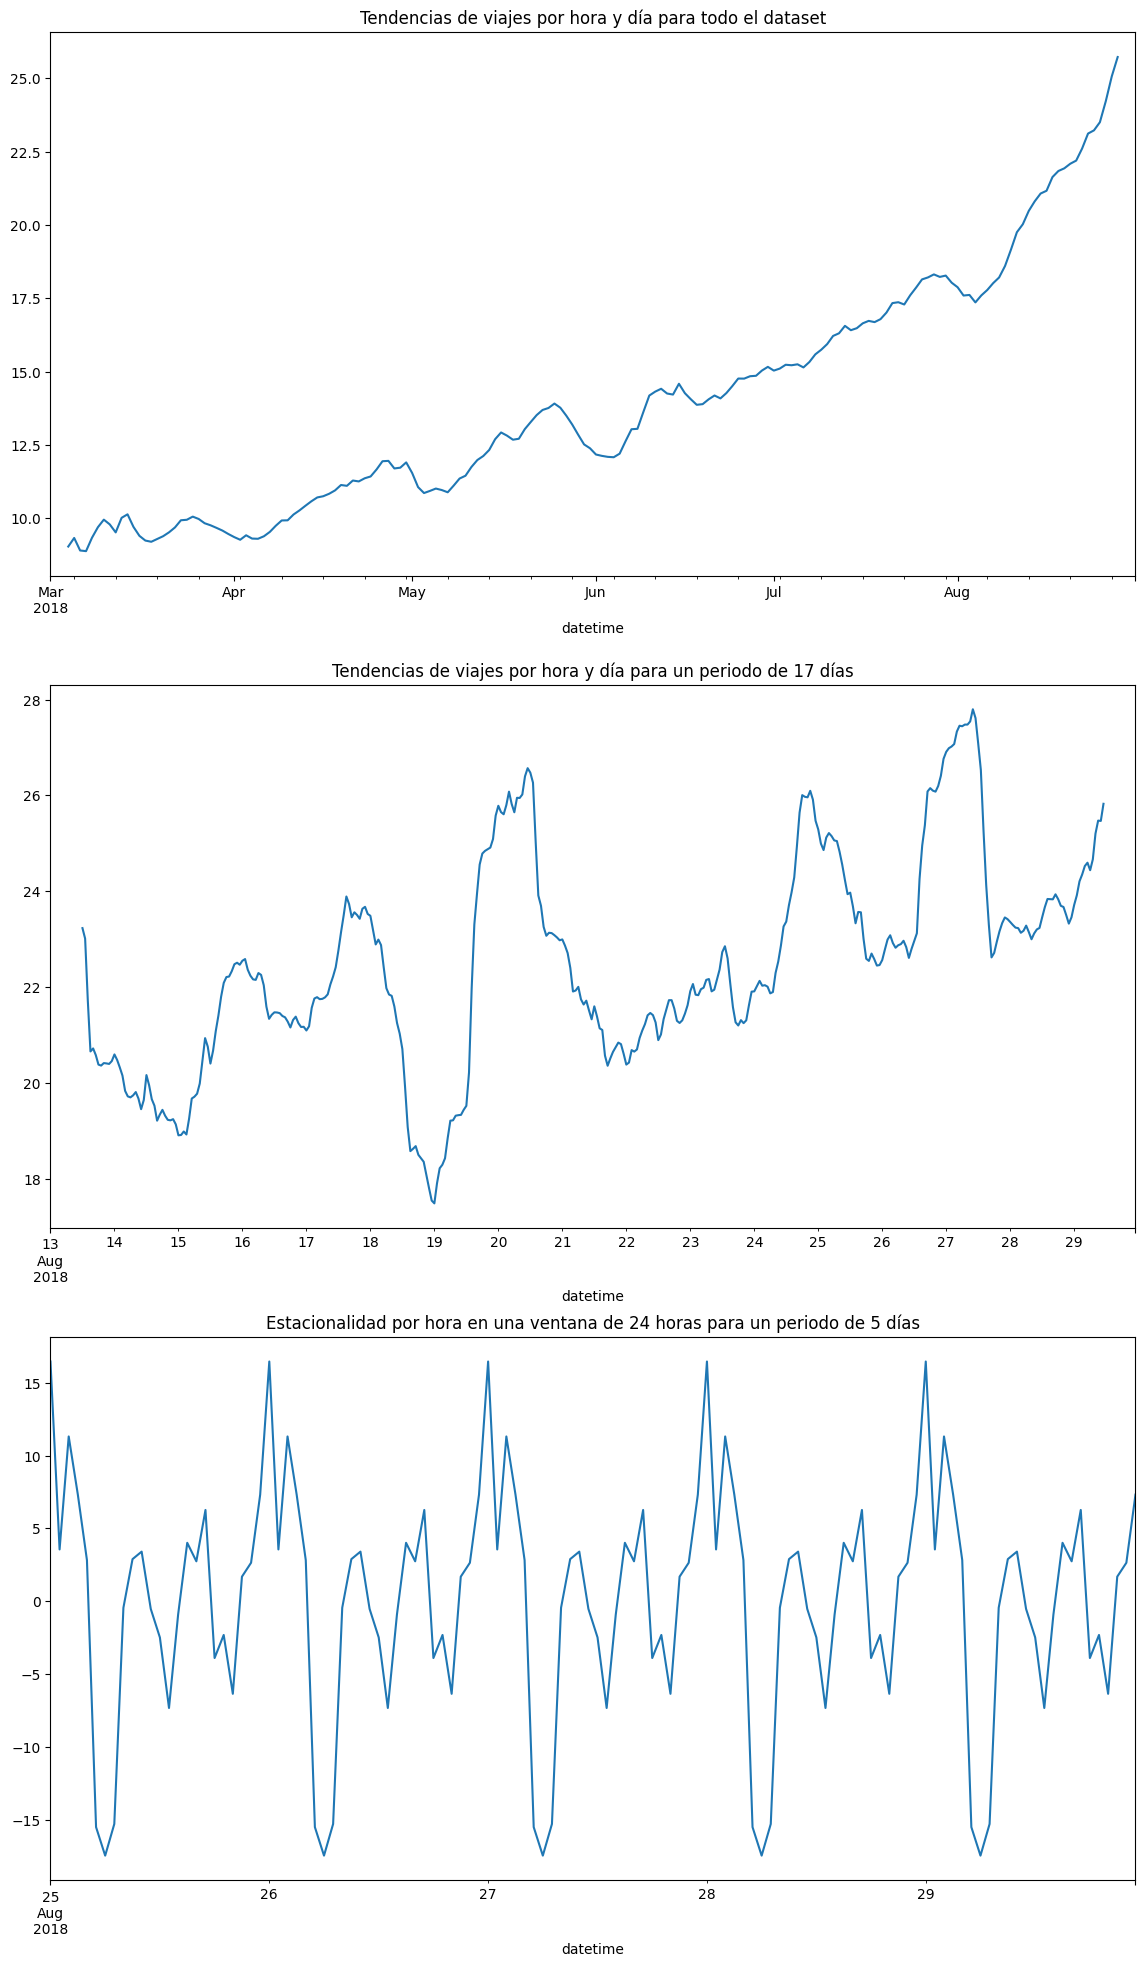

In [19]:
plt.figure(311)

plt.figure(figsize=(14,24))

#Graficando la tendencia por día de todos los datos registrados
plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca())
plt.title('Tendencias de viajes por hora y día para todo el dataset')


#Graficando la tendencia por día de las últimas dos semanas registradas
#Ampliamos la ventana un poco para poder observar las tendencias en las dos semanas completas
plt.subplot(312)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Tendencias de viajes por hora y día para un periodo de 17 días')

#Graficando la estacionalidad por hora en los últimos 5 días para verificar el comportamiento diario
plt.subplot(313)
decomposed_week_by_hour.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad por hora en una ventana de 24 horas para un periodo de 5 días')



**Podemos observar que:**


* **La demanda del servicio de taxi tiene una tendencia a la alta en los meses registrados, de Abril a Junio observamos una baja en el consumo para los primeros días del mes, sin embargo en el resto de los meses no obedece a un comportamiento cíclico, los incrementos en el consumo se observan normalmente al cierre del mes.**


* **La demanda del servicio de taxi estudiado por día y hora en las últimas dos semanas nos muestra tendencias claras:**
    * Los Domingos incrementa abruptamente el consumo de viajes
    * Entre los días Lunes y Miércoles el consumo de viajes se reduce
    * Nuevamente vuelve a incrementar el consumo de viajes entre el Jueves y el Sábado para repetir el ciclo


* **La demanda del servicio de taxi, estudiada por día y hora en los últimos 5 días nos muestra una estacionalidad en donde:**
    * Las últimas horas del día se incrementa la demanda a su pico máximo (horas pico)
    * Las primeras horas del día se decrementa la demanda a su pico mínimo (horas valle)
    * Por la mañana y antes del mediodía se observa un incremento de consumo
    * Cerca del mediodía y hasta antes de las 3pm (aproximadamente) se observa un decremento en el consumo
    * Entre las 3pm y 6pm (aproximadamente) vuelve a incrementar el consumo
    * Entre las 6pm y 8pm (aproximadamente) decrementa el consumo
    * Después de las 8pm (aproximadamente) y al cierre del día, incrementa el consumo para repetir el ciclo.

## Entrenamiento y predicción del modelo

In [20]:
metrics_dict={}

### Definiendo función de evaluación de modelo

In [21]:
def metrics( target_valid,model_predictions):
    mean = model_predictions.mean()
    mse = mean_squared_error(target_valid,model_predictions)
    rmse = mse ** 0.5
    return mean, rmse

### LightGBM sin ajuste de hiperparámetros (modelo benchmark)

In [22]:
model = LGBMRegressor(random_state=12345)
model.fit(train[features], train[target])
predictions = model.predict(test[features])
mean_lgbm_b, rmse_lgbm_b = metrics(predictions,test[target])

print(f"La cantidad media de órdenes predichas es : {round(mean_lgbm_b,2)}",)
print(f'El Error medio cuadrático para las predicciones es: {round(rmse_lgbm_b,2)}')

La cantidad media de órdenes predichas es : 23.27
El Error medio cuadrático para las predicciones es: 8.75


In [23]:
metrics_dict['LightGBM_without_adjustment']=['Modelo LightGBM sin ajuste de hiperparámetros',mean_lgbm_b,rmse_lgbm_b]

### LightGBM con ajuste de hiperparámetros (modelo final)

In [24]:
param_grid={
    'num_leaves':[40,60],
    'max_depth':[5,7],
    'n_estimators':[150,250],
    'learning_rate':[0.1],
    'class_weight':[None,'balanced']
}

In [25]:
gridsearch = GridSearchCV(LGBMRegressor(random_state=12345),param_grid = param_grid,
                          n_jobs=-1,scoring='neg_root_mean_squared_error')

In [26]:
%%time
gridsearch.fit(train[features],train[target])

CPU times: user 1min 52s, sys: 943 ms, total: 1min 53s
Wall time: 1min 54s


GridSearchCV(estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'learning_rate': [0.1], 'max_depth': [5, 7],
                         'n_estimators': [150, 250], 'num_leaves': [40, 60]},
             scoring='neg_root_mean_squared_error')

In [27]:
gridsearch_lgbm_best = gridsearch.best_estimator_

In [28]:
print(gridsearch.best_params_)

{'class_weight': None, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'num_leaves': 40}


In [29]:
%%time
final_lgbm_predicitons= gridsearch_lgbm_best.predict(test[features])
mean_lgbm ,rmse_lgbm = metrics(test[target],final_lgbm_predicitons )
print(f"La cantidad media de órdenes predichas es : {round(mean_lgbm,2)}",)
print(f'El Error medio cuadrático para las predicciones es: {round(rmse_lgbm,2)}')



La cantidad media de órdenes predichas es : 22.3
El Error medio cuadrático para las predicciones es: 8.69
CPU times: user 39.7 ms, sys: 4.07 ms, total: 43.8 ms
Wall time: 16.8 ms


In [30]:
metrics_dict['LightGBM_with_adjustment']=['Modelo LightGBM con ajuste de hiperparámetros',mean_lgbm,rmse_lgbm]

### Catboost sin ajuste de hiperparámetros (modelo bemchmark)

In [31]:
%%time
cb_model = CatBoostRegressor(random_state=12345, loss_function='RMSE', iterations=150, verbose=100)
cb_model.fit(train[features],train[target])
cb_predictions = cb_model.predict(test[features])
mean_cb ,rmse_cb = metrics(test[target], cb_predictions)

Learning rate set to 0.315972
0:	learn: 7.1041283	total: 57.7ms	remaining: 8.6s
100:	learn: 5.1140995	total: 869ms	remaining: 421ms
149:	learn: 4.9211325	total: 1.29s	remaining: 0us
CPU times: user 1.33 s, sys: 4.06 ms, total: 1.33 s
Wall time: 1.51 s


In [32]:
print(f"La cantidad media de órdenes predichas es : {round(mean_cb,2)}",)
print(f'El Error medio cuadrático para las predicciones es: {round(rmse_cb,2)}')

La cantidad media de órdenes predichas es : 21.79
El Error medio cuadrático para las predicciones es: 8.88


In [33]:
metrics_dict['Catboost_without_adjustment']=['Modelo Catboost sin ajuste de hiperparámetros',mean_cb,rmse_cb]

### Catboost con ajuste de hiperparámetros (modelo final)

In [34]:
param_grid={
    'learning_rate':[0.1],
    'depth':[5,10],
    'early_stopping_rounds': [7]
}

In [35]:
cb_gridsearch= GridSearchCV(CatBoostRegressor(random_state=12345,loss_function='RMSE',iterations=150),
                           param_grid=param_grid,n_jobs=-1)

In [36]:
%%time
cb_gridsearch.fit(train[features], train[target], verbose=200)

0:	learn: 7.9563032	total: 7.4ms	remaining: 1.1s
149:	learn: 5.5434814	total: 841ms	remaining: 0us
0:	learn: 7.9584562	total: 6.86ms	remaining: 1.02s
149:	learn: 5.4919594	total: 810ms	remaining: 0us
0:	learn: 7.9088967	total: 5.87ms	remaining: 875ms
149:	learn: 5.4080386	total: 822ms	remaining: 0us
0:	learn: 7.8876434	total: 6.54ms	remaining: 975ms
149:	learn: 5.3130826	total: 835ms	remaining: 0us
0:	learn: 7.0629493	total: 7.49ms	remaining: 1.11s
149:	learn: 5.0363779	total: 794ms	remaining: 0us
0:	learn: 7.9304216	total: 50.5ms	remaining: 7.53s
149:	learn: 4.7696828	total: 7.04s	remaining: 0us
0:	learn: 7.9374143	total: 49.3ms	remaining: 7.35s
149:	learn: 4.8356826	total: 7s	remaining: 0us
0:	learn: 7.8990640	total: 45.7ms	remaining: 6.8s
149:	learn: 4.7751776	total: 6.83s	remaining: 0us
0:	learn: 7.8648671	total: 48.1ms	remaining: 7.16s
149:	learn: 4.6322151	total: 7.18s	remaining: 0us
0:	learn: 7.0438757	total: 44.8ms	remaining: 6.67s
149:	learn: 4.3919829	total: 6.39s	remaining: 

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7f785f09f2e0>,
             n_jobs=-1,
             param_grid={'depth': [5, 10], 'early_stopping_rounds': [7],
                         'learning_rate': [0.1]})

In [37]:
cb_gridsearch_best = cb_gridsearch.best_estimator_

In [38]:
print(cb_gridsearch.best_params_)

{'depth': 5, 'early_stopping_rounds': 7, 'learning_rate': 0.1}


In [39]:
cb_predictions_f = cb_gridsearch_best.predict(test[features])
cb_f_mean , cb_f_rmse = metrics(test[target],cb_predictions_f)
print(f"La cantidad media de órdenes predichas es : {round(cb_f_mean,2)}",)
print(f'El Error medio cuadrático para las predicciones es: {round(cb_f_rmse,2)}')

La cantidad media de órdenes predichas es : 22.04
El Error medio cuadrático para las predicciones es: 8.49


In [40]:
metrics_dict['Catboost_with_adjustment']=['Modelo Catboost con ajuste de hiperparámetros',cb_f_mean,cb_f_rmse]

## Resumen de resultados

In [41]:
metrics_dict

{'LightGBM_without_adjustment': ['Modelo LightGBM sin ajuste de hiperparámetros',
  23.269056603773585,
  8.75157445478309],
 'LightGBM_with_adjustment': ['Modelo LightGBM con ajuste de hiperparámetros',
  22.297624943267806,
  8.693515713376197],
 'Catboost_without_adjustment': ['Modelo Catboost sin ajuste de hiperparámetros',
  21.79451033510037,
  8.882820085879244],
 'Catboost_with_adjustment': ['Modelo Catboost con ajuste de hiperparámetros',
  22.043574002655845,
  8.493103974653605]}

In [42]:
df_metrics= pd.DataFrame(metrics_dict)
df_metrics=df_metrics.T
df_metrics.reset_index(drop=True,inplace=True)
df_metrics.columns=['','Media de la predicción','RMSE de la predicción']
df_metrics = df_metrics.sort_values(by='RMSE de la predicción')
df_metrics.reset_index(drop=True,inplace=True)

catboost_metrics_df = pd.DataFrame(df_metrics.iloc[0])
catboost_metrics_df=catboost_metrics_df.T
catboost_metrics_df['Depth']=5
catboost_metrics_df['Early stopping rounds']=7
catboost_metrics_df['Learning Rate']=0.1
catboost_metrics_df=catboost_metrics_df.T
catboost_metrics_df.columns=['']


In [43]:
df_metrics

,,Media de la predicción,RMSE de la predicción
0,Modelo Catboost con ajuste de hiperparámetros,22.043574,8.493104
1,Modelo LightGBM con ajuste de hiperparámetros,22.297625,8.693516
2,Modelo LightGBM sin ajuste de hiperparámetros,23.269057,8.751574
3,Modelo Catboost sin ajuste de hiperparámetros,21.79451,8.88282


In [44]:
catboost_metrics_df

,
,Modelo Catboost con ajuste de hiperparámetros
Media de la predicción,22.043574
RMSE de la predicción,8.493104
Depth,5
Early stopping rounds,7
Learning Rate,0.1


## Conclusiones

**Conclusiones de los modelos**

**Tal como podemos observar en la tabla anterior:**

* El modelo con mejor desempeño es **Catboost con ajuste de hiperparámetros**, sus métricas fueron:
    * **La cantidad media de órdenes predichas es : 22.04**
    * **El Error medio cuadrático para las predicciones es: 8.49**
    * **Mejores parámetros:**
        * 'depth': 5
        * 'early_stopping_rounds': 7
        * 'learning_rate': 0.1
        
Obtuvimos un RMSE de 8.49 muy por debajo del objetivo (Menor a 48), el costo computacional fue bajo con un tiempo de entrenamiento de 41.2 segundos, las características no necesitaron ser escaladas ni codificadas.


**Conclusiones respecto a los datos:**


* **La demanda del servicio de taxi tiene una tendencia a la alta en los meses registrados, de Abril a Junio observamos una baja en el consumo para los primeros días del mes, sin embargo en el resto de los meses no obedece a un comportamiento cíclico, los incrementos en el consumo se observan normalmente al cierre del mes.**


* **La demanda del servicio de taxi estudiado por día y hora en las últimas dos semanas nos muestra tendencias claras:**
    * Los Domingos incrementa abruptamente el consumo de viajes
    * Entre los días Lunes y Miércoles el consumo de viajes se reduce
    * Nuevamente vuelve a incrementar el consumo de viajes entre el Jueves y el Sábado para repetir el ciclo


* **La demanda del servicio de taxi, estudiada por día y hora en los últimos 5 días nos muestra una estacionalidad en donde:**
    * Las últimas horas del día se incrementa la demanda a su pico máximo (horas pico)
    * Las primeras horas del día se decrementa la demanda a su pico mínimo (horas valle)
    * Por la mañana y antes del mediodía se observa un incremento de consumo
    * Cerca del mediodía y hasta antes de las 3pm (aproximadamente) se observa un decremento en el consumo
    * Entre las 3pm y 6pm (aproximadamente) vuelve a incrementar el consumo
    * Entre las 6pm y 8pm (aproximadamente) decrementa el consumo
    * Después de las 8pm (aproximadamente) y al cierre del día, incrementa el consumo para repetir el ciclo.

